In [1]:
import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import csv
import random
import re
import os
import unicodedata
import codecs
from io import open
import itertools
import math
import json
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import matplotlib.pyplot as plt

USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/Users/umairasif/Documents/Personal/Univeristy/Bock 1/Assignment block 2/NLP Chatbot Project/.venv/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module

In [2]:
# Default word tokens
PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token
MAX_LENGTH = 10  # Maximum sentence length to consider
MIN_COUNT = 3    # Minimum word count threshold for trimming
small_batch_size = 5

# Configure models parameters/ hyper parameters
model_name = 'cb_model'
attn_model = 'dot'
# attn_model = 'general'
#``attn_model = 'concat'``
hidden_size = 600
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.2
batch_size = 128

# Configure training/optimization/ / hyper parameters
clip = 50.0
teacher_forcing_ratio = 0.6
learning_rate = 0.0003
decoder_learning_ratio = 3.0
n_iteration = 500
print_every = 1
save_every = 500

# Declared default parameters used in chatbot
loadFilename = None
checkpoint_iter = 3000
training_losses = []
validation_losses = []
cnn_losses = []
mlp_losses = []




In [3]:
# Helper functions
def indexesFromSentence(voc, sentence):
    return [voc.word2index[word] for word in sentence.split(' ')] + [EOS_token]


def zeroPadding(l, fillvalue=PAD_token):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

def binaryMatrix(l, value=PAD_token):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m

# Returns padded input sequence tensor and lengths
def inputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    padVar = torch.LongTensor(padList)
    return padVar, lengths

# Returns padded target sequence tensor, padding mask, and max target length
def outputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    mask = binaryMatrix(padList)
    mask = torch.BoolTensor(mask)
    padVar = torch.LongTensor(padList)
    return padVar, mask, max_target_len

# Returns all items for a given batch of pairs
def batch2TrainData(voc, pair_batch):
    pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
    inp, lengths = inputVar(input_batch, voc)
    output, mask, max_target_len = outputVar(output_batch, voc)
    return inp, lengths, output, mask, max_target_len


def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

# Read query/response pairs and return a voc object
def readVocs(datafile, corpus_name):
    print("Reading lines...")
    lines = open(datafile, encoding='utf-8').read().strip().split('\n')
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    voc = Voc(corpus_name)
    return voc, pairs

# Returns True if both sentences in a pair 'p' are under the MAX_LENGTH threshold
def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH

# Filter pairs using the ``filterPair`` condition
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]


In [4]:
corpus_name = "movie-corpus"
corpus = os.path.join("data", corpus_name)

def printLines(file, n=10):
    with open(file, 'rb') as datafile:
        lines = datafile.readlines()
    for line in lines[:n]:
        print(line)

printLines(os.path.join(corpus, "utterances.jsonl"))

b'{"id": "L1045", "conversation_id": "L1044", "text": "They do not!", "speaker": "u0", "meta": {"movie_id": "m0", "parsed": [{"rt": 1, "toks": [{"tok": "They", "tag": "PRP", "dep": "nsubj", "up": 1, "dn": []}, {"tok": "do", "tag": "VBP", "dep": "ROOT", "dn": [0, 2, 3]}, {"tok": "not", "tag": "RB", "dep": "neg", "up": 1, "dn": []}, {"tok": "!", "tag": ".", "dep": "punct", "up": 1, "dn": []}]}]}, "reply-to": "L1044", "timestamp": null, "vectors": []}\n'
b'{"id": "L1044", "conversation_id": "L1044", "text": "They do to!", "speaker": "u2", "meta": {"movie_id": "m0", "parsed": [{"rt": 1, "toks": [{"tok": "They", "tag": "PRP", "dep": "nsubj", "up": 1, "dn": []}, {"tok": "do", "tag": "VBP", "dep": "ROOT", "dn": [0, 2, 3]}, {"tok": "to", "tag": "TO", "dep": "dobj", "up": 1, "dn": []}, {"tok": "!", "tag": ".", "dep": "punct", "up": 1, "dn": []}]}]}, "reply-to": null, "timestamp": null, "vectors": []}\n'
b'{"id": "L985", "conversation_id": "L984", "text": "I hope so.", "speaker": "u0", "meta": {

In [5]:
# Splits each line of the file to create lines and conversations
def loadLinesAndConversations(fileName):
    lines = {}
    conversations = {}
    with open(fileName, 'r', encoding='iso-8859-1') as f:
        for line in f:
            lineJson = json.loads(line)
            # Extract fields for line object
            lineObj = {}
            lineObj["lineID"] = lineJson["id"]
            lineObj["characterID"] = lineJson["speaker"]
            lineObj["text"] = lineJson["text"]
            lines[lineObj['lineID']] = lineObj

            # Extract fields for conversation object
            if lineJson["conversation_id"] not in conversations:
                convObj = {}
                convObj["conversationID"] = lineJson["conversation_id"]
                convObj["movieID"] = lineJson["meta"]["movie_id"]
                convObj["lines"] = [lineObj]
            else:
                convObj = conversations[lineJson["conversation_id"]]
                convObj["lines"].insert(0, lineObj)
            conversations[convObj["conversationID"]] = convObj

    return lines, conversations


# Extracts pairs of sentences from conversations
def extractSentencePairs(conversations):
    qa_pairs = []
    for conversation in conversations.values():
        # Iterate over all the lines of the conversation
        for i in range(len(conversation["lines"]) - 1):  # We ignore the last line (no answer for it)
            inputLine = conversation["lines"][i]["text"].strip()
            targetLine = conversation["lines"][i+1]["text"].strip()
            # Filter wrong samples (if one of the lists is empty)
            if inputLine and targetLine:
                qa_pairs.append([inputLine, targetLine])
    return qa_pairs

In [6]:
# Define path to new file
datafile = os.path.join(corpus, "formatted_movie_lines.txt")

delimiter = '\t'
# Unescape the delimiter
delimiter = str(codecs.decode(delimiter, "unicode_escape"))

# Initialize lines dict and conversations dict
lines = {}
conversations = {}
# Load lines and conversations
print("\nProcessing corpus into lines and conversations...")
lines, conversations = loadLinesAndConversations(os.path.join(corpus, "utterances.jsonl"))

# Write new csv file
print("\nWriting newly formatted file...")
with open(datafile, 'w', encoding='utf-8') as outputfile:
    writer = csv.writer(outputfile, delimiter=delimiter, lineterminator='\n')
    for pair in extractSentencePairs(conversations):
        writer.writerow(pair)

# Print a sample of lines
print("\nSample lines from file:")
printLines(datafile)


Processing corpus into lines and conversations...

Writing newly formatted file...

Sample lines from file:
b'They do to!\tThey do not!\n'
b'She okay?\tI hope so.\n'
b"Wow\tLet's go.\n"
b'"I\'m kidding.  You know how sometimes you just become this ""persona""?  And you don\'t know how to quit?"\tNo\n'
b"No\tOkay -- you're gonna need to learn how to lie.\n"
b"I figured you'd get to the good stuff eventually.\tWhat good stuff?\n"
b'What good stuff?\t"The ""real you""."\n'
b'"The ""real you""."\tLike my fear of wearing pastels?\n'
b'do you listen to this crap?\tWhat crap?\n'
b"What crap?\tMe.  This endless ...blonde babble. I'm like, boring myself.\n"


In [7]:
class Voc:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3  # Count SOS, EOS, PAD

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    # Remove words below a certain count threshold
    def trim(self, min_count):
        if self.trimmed:
            return
        self.trimmed = True

        keep_words = []

        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words {} / {} = {:.4f}'.format(
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        # Reinitialize dictionaries
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3 # Count default tokens

        for word in keep_words:
            self.addWord(word)

In [8]:
# Using the functions defined above, return a populated voc object and pairs list
def loadPrepareData(corpus, corpus_name, datafile, save_dir):
    print("Start preparing training data ...")
    voc, pairs = readVocs(datafile, corpus_name)
    print(f"Read {len(pairs)} sentence pairs")
    pairs = filterPairs(pairs)
    print(f"Trimmed to {len(pairs)} sentence pairs")
    print("Counting words...")
    for pair in pairs:
        voc.addSentence(pair[0])
        voc.addSentence(pair[1])
    print(f"Counted words: {voc.num_words}")
    return voc, pairs

# Load/Assemble voc and pairs
save_dir = os.path.join("data", "save")
voc, pairs = loadPrepareData(corpus, corpus_name, datafile, save_dir)

# Split pairs into training and validation sets
train_pairs, val_pairs = train_test_split(pairs, test_size=0.1, random_state=42)

print(f"Training pairs: {len(train_pairs)}")
print(f"Validation pairs: {len(val_pairs)}")

def create_data_loader(voc, pairs, batch_size):
    inputs, targets = [], []
    skipped_pairs = 0

    for pair in pairs:
        inp, lengths, outp, mask, max_target_len = batch2TrainData(voc, [pair])

        if inp.size(1) != outp.size(1):
            min_len = min(inp.size(1), outp.size(1))
            inp = inp[:, :min_len]
            outp = outp[:, :min_len]

        if inp.size(1) == outp.size(1):
            inputs.append(inp.squeeze(1))
            targets.append(outp.squeeze(1))
        else:
            skipped_pairs += 1

    print(f"Skipped pairs: {skipped_pairs}")

    if len(inputs) == 0 or len(targets) == 0:
        raise ValueError("No valid pairs found for DataLoader.")

    inputs = torch.cat(inputs, dim=0)
    targets = torch.cat(targets, dim=0)

    if inputs.size(0) != targets.size(0):
        min_samples = min(inputs.size(0), targets.size(0))
        inputs = inputs[:min_samples]
        targets = targets[:min_samples]

    print(f"Final Inputs shape: {inputs.shape}")
    print(f"Final Targets shape: {targets.shape}")

    dataset = TensorDataset(inputs, targets)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Create DataLoaders for training and validation
train_loader = create_data_loader(voc, train_pairs, batch_size=16)
val_loader = create_data_loader(voc, val_pairs, batch_size=16)


Start preparing training data ...
Reading lines...
Read 221282 sentence pairs
Trimmed to 64313 sentence pairs
Counting words...
Counted words: 18082
Training pairs: 57881
Validation pairs: 6432
Skipped pairs: 0
Final Inputs shape: torch.Size([362183])
Final Targets shape: torch.Size([362183])
Skipped pairs: 0
Final Inputs shape: torch.Size([40088])
Final Targets shape: torch.Size([40088])


In [9]:
def trimRareWords(voc, pairs, MIN_COUNT):
    # Trim words used under the MIN_COUNT from the voc
    voc.trim(MIN_COUNT)
    # Filter out pairs with trimmed words
    keep_pairs = []
    for pair in pairs:
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True
        # Check input sentence
        for word in input_sentence.split(' '):
            if word not in voc.word2index:
                keep_input = False
                break
        # Check output sentence
        for word in output_sentence.split(' '):
            if word not in voc.word2index:
                keep_output = False
                break

        # Only keep pairs that do not contain trimmed word(s) in their input or output sentence
        if keep_input and keep_output:
            keep_pairs.append(pair)

    print("Trimmed from {} pairs to {}, {:.4f} of total".format(len(pairs), len(keep_pairs), len(keep_pairs) / len(pairs)))
    return keep_pairs


# Trim voc and pairs
pairs = trimRareWords(voc, pairs, MIN_COUNT)

keep_words 7833 / 18079 = 0.4333
Trimmed from 64313 pairs to 53131, 0.8261 of total


In [10]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding

        # Initialize GRU; the input_size and hidden_size parameters are both set to 'hidden_size'
        #   because our input size is a word embedding with number of features == hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    def forward(self, input_seq, input_lengths, hidden=None):
        # Convert word indexes to embeddings
        embedded = self.embedding(input_seq)
        # Pack padded batch of sequences for RNN module
        packed = nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        # Forward pass through GRU
        outputs, hidden = self.gru(packed, hidden)
        # Unpack padding
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        # Sum bidirectional GRU outputs
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        # Return output and final hidden state
        return outputs, hidden

In [11]:
# CNN Model
class CNNChatbot(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, kernel_sizes, num_filters, dropout):
        super(CNNChatbot, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([
            nn.Conv2d(1, num_filters, (k, embedding_dim)) for k in kernel_sizes
        ])
        self.fc = nn.Linear(len(kernel_sizes) * num_filters, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x.float()  # Ensure input is float
        embedded = self.embedding(x.long()).unsqueeze(1)  # (batch_size, 1, seq_len, embedding_dim)
        conved = [nn.functional.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        pooled = [nn.functional.max_pool1d(conv, conv.size(2)).squeeze(2) for conv in conved]
        cat = self.dropout(torch.cat(pooled, dim=1))  # (batch_size, num_filters * len(kernel_sizes))
        output = self.fc(cat)  # (batch_size, vocab_size)
        return output.unsqueeze(1).expand(-1, x.size(1), -1)  # Ensure (batch_size, seq_len, vocab_size)


# MLP Model
class MLPChatbot(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout):
        super(MLPChatbot, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)  # Embedding layer
        self.fc1 = nn.Linear(embedding_dim * 10, hidden_dim)  # Adjust input_dim based on embedding
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x).view(x.size(0), -1)  # Embed and flatten input
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        output = self.fc2(x)
        return output.unsqueeze(1).expand(-1, 10, -1)  # Ensure (batch_size, seq_len, vocab_size)



In [12]:
# Luong attention layer
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(hidden_size))

    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        return torch.sum(hidden * energy, dim=2)

    def concat_score(self, hidden, encoder_output):
        energy = self.attn(torch.cat((hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        return torch.sum(self.v * energy, dim=2)

    def forward(self, hidden, encoder_outputs):
        # Calculate the attention weights (energies) based on the given method
        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)

        # Transpose max_length and batch_size dimensions
        attn_energies = attn_energies.t()

        # Return the softmax normalized probability scores (with added dimension)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)


In [13]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # Define layers
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_step, last_hidden, encoder_outputs):
        # Note: we run this one step (word) at a time
        # Get embedding of current input word
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        # Forward through unidirectional GRU
        rnn_output, hidden = self.gru(embedded, last_hidden)
        # Calculate attention weights from the current GRU output
        attn_weights = self.attn(rnn_output, encoder_outputs)
        # Multiply attention weights to encoder outputs to get new "weighted sum" context vector
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        # Concatenate weighted context vector and GRU output using Luong eq. 5
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        # Predict next word using Luong eq. 6
        output = self.out(concat_output)
        output = F.softmax(output, dim=1)
        # Return output and final hidden state
        return output, hidden

In [14]:
def maskNLLLoss(inp, target, mask):
    nTotal = mask.sum()
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = crossEntropy.masked_select(mask).mean()
    loss = loss.to(device)
    return loss, nTotal.item()

In [15]:
def train(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, embedding,
          encoder_optimizer, decoder_optimizer, batch_size, clip, max_length=MAX_LENGTH):

    # Zero gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Set device options
    input_variable = input_variable.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)
    # Lengths for RNN packing should always be on the CPU
    lengths = lengths.to("cpu")

    # Initialize variables
    loss = 0
    print_losses = []
    n_totals = 0

    # Forward pass through encoder
    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

    # Create initial decoder input (start with SOS tokens for each sentence)
    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)

    # Set initial decoder hidden state to the encoder's final hidden state
    decoder_hidden = encoder_hidden[:decoder.n_layers]

    # Determine if we are using teacher forcing this iteration
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    # Forward batch of sequences through decoder one time step at a time
    if use_teacher_forcing:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # Teacher forcing: next input is current target
            decoder_input = target_variable[t].view(1, -1)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
    else:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # No teacher forcing: next input is decoder's own current output
            _, topi = decoder_output.topk(1)
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
            decoder_input = decoder_input.to(device)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal

    # Perform backpropagation
    loss.backward()

    # Clip gradients: gradients are modified in place
    _ = nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    # Adjust model weights
    encoder_optimizer.step()
    decoder_optimizer.step()

    return sum(print_losses) / n_totals

In [16]:
def trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer, embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size, print_every, save_every, clip, corpus_name, loadFilename, training_losses, validation_losses, validation_pairs=None):

    # Load batches for each iteration
    training_batches = [batch2TrainData(voc, [random.choice(pairs) for _ in range(batch_size)])
                      for _ in range(n_iteration)]

    # Initializations
    print('Initializing ...')
    start_iteration = 1
    print_loss = 0
    if loadFilename:
        start_iteration = checkpoint['iteration'] + 1

    # Training loop
    print("Training...")
    for iteration in range(start_iteration, n_iteration + 1):
        training_batch = training_batches[iteration - 1]
        # Extract fields from batch
        input_variable, lengths, target_variable, mask, max_target_len = training_batch

        # Run a training iteration with batch
        loss = train(input_variable, lengths, target_variable, mask, max_target_len, encoder,
                     decoder, embedding, encoder_optimizer, decoder_optimizer, batch_size, clip)
        print_loss += loss
        
        # Record training loss
        training_losses.append(loss)
        
        # Optional validation loss computation
        if validation_pairs and iteration % print_every == 0:
            val_batch = batch2TrainData(voc, [random.choice(validation_pairs) for _ in range(batch_size)])
            val_input, val_lengths, val_target, val_mask, val_max_target_len = val_batch
            val_loss = train(val_input, val_lengths, val_target, val_mask, val_max_target_len, encoder,
                             decoder, embedding, encoder_optimizer, decoder_optimizer, batch_size, clip, train=False)
            validation_losses.append(val_loss)

        # Print progress
        if iteration % print_every == 0:
            print_loss_avg = print_loss / print_every
            print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".format(iteration, iteration / n_iteration * 100, print_loss_avg))
            print_loss = 0

        # Save checkpoint
        if (iteration % save_every == 0):
            directory = os.path.join(save_dir, model_name, corpus_name, '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size))
            if not os.path.exists(directory):
                os.makedirs(directory)
            torch.save({
                'iteration': iteration,
                'en': encoder.state_dict(),
                'de': decoder.state_dict(),
                'en_opt': encoder_optimizer.state_dict(),
                'de_opt': decoder_optimizer.state_dict(),
                'loss': loss,
                'voc_dict': voc.__dict__,
                'embedding': embedding.state_dict()
            }, os.path.join(directory, '{}_{}.tar'.format(iteration, 'checkpoint')))
            
        # Save metrics to file
        with open(os.path.join(save_dir, 'metrics.json'), 'w') as f:
            json.dump({'training_losses': training_losses, 'validation_losses': validation_losses}, f)


In [17]:
def train_cnn_mlp_model(model, data_loader, criterion, optimizer, epochs=5):
    model.train()
    all_losses = []
    for epoch in range(epochs):
        total_loss = 0
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)  # Model output: (batch_size, seq_len, vocab_size)
            outputs = outputs.reshape(-1, outputs.size(-1))  # Flatten outputs
            targets = targets.reshape(-1)  # Flatten targets

            # Calculate loss
            loss = criterion(outputs, targets)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        avg_loss = total_loss / len(data_loader)
        all_losses.append(avg_loss)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")
    return all_losses


In [18]:
def prepare_sample_data(vocab_size, seq_len, num_samples=1000):
    """
    Generate random sample data for demonstration purposes.
    """
    inputs = torch.randint(0, vocab_size, (num_samples, seq_len))  # Random input sequences
    targets = torch.randint(0, vocab_size, (num_samples, seq_len))  # Random target sequences
    dataset = TensorDataset(inputs, targets)
    return DataLoader(dataset, batch_size=16, shuffle=True)

In [19]:
class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, input_length, max_length):
        # Forward input through encoder model
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        # Prepare encoder's final hidden layer to be first hidden input to the decoder
        decoder_hidden = encoder_hidden[:decoder.n_layers]
        # Initialize decoder input with SOS_token
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token
        # Initialize tensors to append decoded words to
        all_tokens = torch.zeros([0], device=device, dtype=torch.long)
        all_scores = torch.zeros([0], device=device)
        # Iteratively decode one word token at a time
        for _ in range(max_length):
            # Forward pass through decoder
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            # Obtain most likely word token and its softmax score
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            # Record token and score
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            # Prepare current token to be next decoder input (add a dimension)
            decoder_input = torch.unsqueeze(decoder_input, 0)
        # Return collections of word tokens and scores
        return all_tokens, all_scores

In [20]:
# Rule-based fallback responses
rule_based_responses = {
    "hello": "Hi there! How can I assist you?",
    "bye": "Goodbye! Have a great day!",
    "thanks": "You're welcome!",
    "who are you": "I am a rule-based chatbot."
}

# Rule-based response function
def get_rule_based_response(user_input):
    """Fetch a response for a predefined input or return None."""
    return rule_based_responses.get(user_input.lower(), None)

In [21]:
def evaluate(encoder, decoder, searcher, voc, sentence, max_length=MAX_LENGTH):
    ### Format input sentence as a batch
    # words -> indexes
    indexes_batch = [indexesFromSentence(voc, sentence)]
    # Create lengths tensor
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    # Transpose dimensions of batch to match models' expectations
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)
    # Use appropriate device
    input_batch = input_batch.to(device)
    lengths = lengths.to("cpu")
    # Decode sentence with searcher
    tokens, scores = searcher(input_batch, lengths, max_length)
    # indexes -> words
    decoded_words = [voc.index2word[token.item()] for token in tokens]
    return decoded_words


def evaluateInput(encoder, decoder, searcher, voc):
    input_sentence = ''
    while(1):
        try:
            # Get input sentence
            input_sentence = input('> ')
            # Check if it is quit case
            if input_sentence == 'q' or input_sentence == 'quit': break
            
            # Check for rule-based response
            rule_response = get_rule_based_response(input_sentence)
            if rule_response:
                print("Bot (Rule-Based):", rule_response)
                continue
            
            # Normalize sentence
            input_sentence = normalizeString(input_sentence)
            # Evaluate sentence
            output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
            # Format and print response sentence
            output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
            print('Bot:', ' '.join(output_words))

        except KeyError:
            print("Error: Encountered unknown word.")

In [22]:
def evaluate_cnn_mlp_model(model, data_loader):
    model.eval()
    bleu_scores = []
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)  # Shape: (batch_size, seq_len, vocab_size)
            outputs = outputs.argmax(dim=2)  # Predicted tokens: (batch_size, seq_len)

            for i in range(inputs.size(0)):  # Loop through the batch
                ref = " ".join(map(str, targets[i].tolist()))  # Reference sentence
                cand = " ".join(map(str, outputs[i].tolist()))  # Predicted sentence
                bleu_scores.append(calculate_bleu(ref, cand))

    avg_bleu = sum(bleu_scores) / len(bleu_scores)
    print(f"Average BLEU Score: {avg_bleu:.4f}")
    return avg_bleu


In [23]:
def plot_metrics(metrics, title, ylabel):
    plt.figure(figsize=(10, 6))
    plt.plot(metrics, marker='o', label=ylabel, color='blue')
    plt.title(title, fontsize=16)
    plt.xlabel('Iterations', fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.savefig(os.path.join(save_dir, title+'_curve.png'))
    plt.show()
    

In [24]:
def calculate_bleu(reference, candidate):
    """
    Calculate BLEU score between reference and candidate sentences.
    - `reference` and `candidate` are strings.
    """
    reference = [reference.split()]  # Reference is a list of token lists
    candidate = candidate.split()   # Candidate is a single list of tokens
    smooth_fn = SmoothingFunction().method4
    return sentence_bleu(reference, candidate, smoothing_function=smooth_fn)

In [25]:
# Load model if a ``loadFilename`` is provided
if loadFilename:
    # If loading on same machine the model was trained on
    checkpoint = torch.load(loadFilename)
    # If loading a model trained on GPU to CPU
    #checkpoint = torch.load(loadFilename, map_location=torch.device('cpu'))
    encoder_sd = checkpoint['en']
    decoder_sd = checkpoint['de']
    encoder_optimizer_sd = checkpoint['en_opt']
    decoder_optimizer_sd = checkpoint['de_opt']
    embedding_sd = checkpoint['embedding']
    voc.__dict__ = checkpoint['voc_dict']


print('Building encoder and decoder ...')
# Initialize word embeddings
embedding = nn.Embedding(voc.num_words, hidden_size)
if loadFilename:
    embedding.load_state_dict(embedding_sd)
# Initialize encoder & decoder models
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)
if loadFilename:
    encoder.load_state_dict(encoder_sd)
    decoder.load_state_dict(decoder_sd)
# Use appropriate device
encoder = encoder.to(device)
decoder = decoder.to(device)
print('Models built and ready to go!')


Building encoder and decoder ...
Models built and ready to go!


In [26]:
# Ensure dropout layers are in train mode
encoder.train()
decoder.train()

# Initialize optimizers
print('Building optimizers ...')
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
if loadFilename:
    encoder_optimizer.load_state_dict(encoder_optimizer_sd)
    decoder_optimizer.load_state_dict(decoder_optimizer_sd)

# If you have CUDA, configure CUDA to call
for state in encoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

for state in decoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

# Run training iterations
print("Starting Training!")
trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer,
           embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size,
           print_every, save_every, clip, corpus_name, loadFilename, training_losses, validation_losses)

Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 1; Percent complete: 0.2%; Average loss: 8.9598
Iteration: 2; Percent complete: 0.4%; Average loss: 8.7249
Iteration: 3; Percent complete: 0.6%; Average loss: 7.9663
Iteration: 4; Percent complete: 0.8%; Average loss: 6.9797
Iteration: 5; Percent complete: 1.0%; Average loss: 7.2556
Iteration: 6; Percent complete: 1.2%; Average loss: 6.7921
Iteration: 7; Percent complete: 1.4%; Average loss: 6.1593
Iteration: 8; Percent complete: 1.6%; Average loss: 5.8931
Iteration: 9; Percent complete: 1.8%; Average loss: 5.7377
Iteration: 10; Percent complete: 2.0%; Average loss: 5.4375
Iteration: 11; Percent complete: 2.2%; Average loss: 4.9964
Iteration: 12; Percent complete: 2.4%; Average loss: 5.1786
Iteration: 13; Percent complete: 2.6%; Average loss: 5.3036
Iteration: 14; Percent complete: 2.8%; Average loss: 5.1666
Iteration: 15; Percent complete: 3.0%; Average loss: 5.1194
Iteration: 16; Percent complete: 3.2%

In [27]:
def train_and_evaluate_cnn_mlp(vocab_size, seq_len, embedding_dim, hidden_dim, output_dim, kernel_sizes, num_filters, dropout, epochs=5):
    
    data_loader = prepare_sample_data(vocab_size, seq_len)

    # CNN Model
    cnn_model = CNNChatbot(vocab_size, embedding_dim, output_dim, kernel_sizes, num_filters, dropout).to(device)
    cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
    cnn_criterion = nn.CrossEntropyLoss()
    
    print("Training CNN Model...")
    cnn_losses = train_cnn_mlp_model(cnn_model, data_loader, cnn_criterion, cnn_optimizer, epochs)
    plot_metrics(cnn_losses, "CNN Training Loss", "Loss")
    
    print("Evaluating CNN Model on Validation Data...")
    cnn_bleu = evaluate_cnn_mlp_model(cnn_model, data_loader)
    print(f"CNN BLEU Score: {cnn_bleu:.4f}")

    # MLP Model
    mlp_model = MLPChatbot(
        vocab_size=vocab_size,
        embedding_dim=embedding_dim,
        hidden_dim=hidden_dim,
        output_dim=output_dim,
        dropout=dropout
    ).to(device)

    mlp_optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)
    mlp_criterion = nn.CrossEntropyLoss()
    print("Training MLP Model...")
    mlp_losses = train_cnn_mlp_model(mlp_model, data_loader, mlp_criterion, mlp_optimizer, epochs)
    plot_metrics(mlp_losses, "MLP Training Loss", "Loss")
    print("Evaluating MLP Model on Validation Data...")
    mlp_bleu = evaluate_cnn_mlp_model(mlp_model, data_loader)
    print(f"MLP BLEU Score: {mlp_bleu:.4f}")


Starting Training for CNN and MLP!
Training CNN Model...
Epoch 1/500, Loss: 9.2003
Epoch 2/500, Loss: 8.5850
Epoch 3/500, Loss: 8.2289
Epoch 4/500, Loss: 7.9168
Epoch 5/500, Loss: 7.5484
Epoch 6/500, Loss: 7.0974
Epoch 7/500, Loss: 6.5468
Epoch 8/500, Loss: 5.9142
Epoch 9/500, Loss: 5.2869
Epoch 10/500, Loss: 4.7504
Epoch 11/500, Loss: 4.4059
Epoch 12/500, Loss: 4.1318
Epoch 13/500, Loss: 4.0134
Epoch 14/500, Loss: 3.8912
Epoch 15/500, Loss: 3.8116
Epoch 16/500, Loss: 3.7281
Epoch 17/500, Loss: 3.6637
Epoch 18/500, Loss: 3.6167
Epoch 19/500, Loss: 3.5037
Epoch 20/500, Loss: 3.4947
Epoch 21/500, Loss: 3.4506
Epoch 22/500, Loss: 3.4038
Epoch 23/500, Loss: 3.3777
Epoch 24/500, Loss: 3.3524
Epoch 25/500, Loss: 3.2924
Epoch 26/500, Loss: 3.2838
Epoch 27/500, Loss: 3.2673
Epoch 28/500, Loss: 3.2352
Epoch 29/500, Loss: 3.1917
Epoch 30/500, Loss: 3.1993
Epoch 31/500, Loss: 3.1391
Epoch 32/500, Loss: 3.1333
Epoch 33/500, Loss: 3.1192
Epoch 34/500, Loss: 3.1137
Epoch 35/500, Loss: 3.0905
Epoch 3

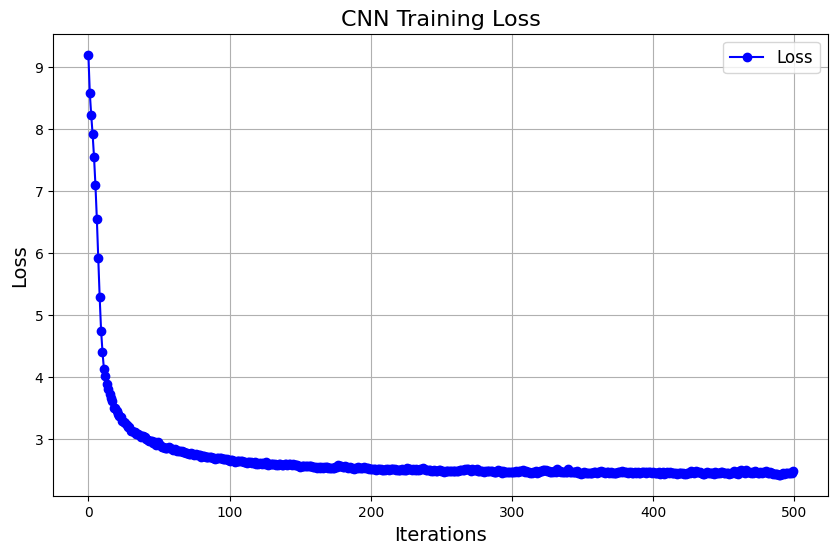

Evaluating CNN Model on Validation Data...
Average BLEU Score: 0.0235
CNN BLEU Score: 0.0235
Training MLP Model...
Epoch 1/500, Loss: 9.3287
Epoch 2/500, Loss: 5.1425
Epoch 3/500, Loss: 4.2279
Epoch 4/500, Loss: 6.2623
Epoch 5/500, Loss: 6.3047
Epoch 6/500, Loss: 5.4758
Epoch 7/500, Loss: 4.6264
Epoch 8/500, Loss: 3.9893
Epoch 9/500, Loss: 3.6371
Epoch 10/500, Loss: 3.4262
Epoch 11/500, Loss: 3.2467
Epoch 12/500, Loss: 3.1367
Epoch 13/500, Loss: 3.0700
Epoch 14/500, Loss: 3.0211
Epoch 15/500, Loss: 2.9559
Epoch 16/500, Loss: 2.9148
Epoch 17/500, Loss: 2.8993
Epoch 18/500, Loss: 2.8652
Epoch 19/500, Loss: 2.8792
Epoch 20/500, Loss: 2.8651
Epoch 21/500, Loss: 2.8568
Epoch 22/500, Loss: 2.8370
Epoch 23/500, Loss: 2.8236
Epoch 24/500, Loss: 2.8396
Epoch 25/500, Loss: 2.8378
Epoch 26/500, Loss: 2.8525
Epoch 27/500, Loss: 2.8395
Epoch 28/500, Loss: 2.8468
Epoch 29/500, Loss: 2.8489
Epoch 30/500, Loss: 2.8889
Epoch 31/500, Loss: 2.8858
Epoch 32/500, Loss: 2.9056
Epoch 33/500, Loss: 2.8969
Epo

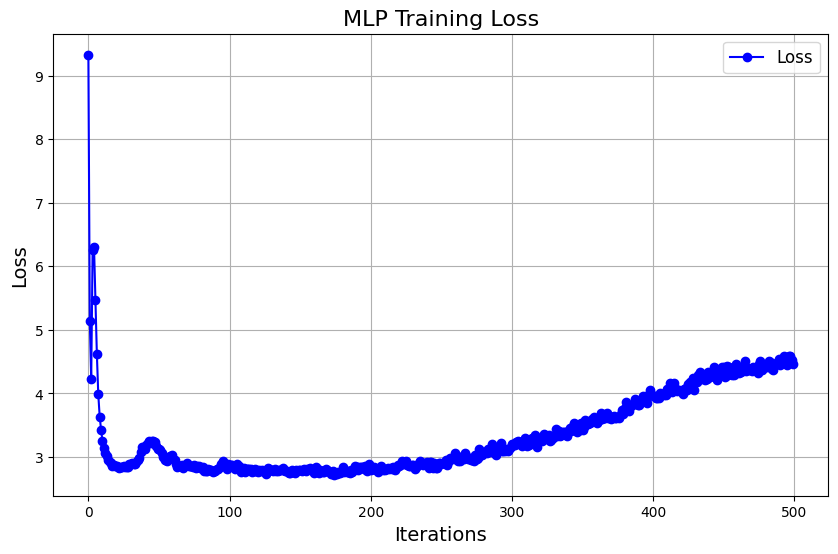

Evaluating MLP Model on Validation Data...
Average BLEU Score: 0.0139
MLP BLEU Score: 0.0139


In [28]:
print("Starting Training for CNN and MLP!")
train_and_evaluate_cnn_mlp(
    vocab_size=voc.num_words,
    seq_len=MAX_LENGTH,
    embedding_dim=hidden_size,  # Reuse RNN hidden size as embedding_dim
    hidden_dim=hidden_size,     # Use the same hidden_size for MLP
    output_dim=voc.num_words,   # Same vocabulary size for output
    kernel_sizes=[2, 3, 4],     # CNN-specific parameter
    num_filters=16,             # CNN-specific parameter
    dropout=dropout,
    epochs=n_iteration  # Same training duration
)

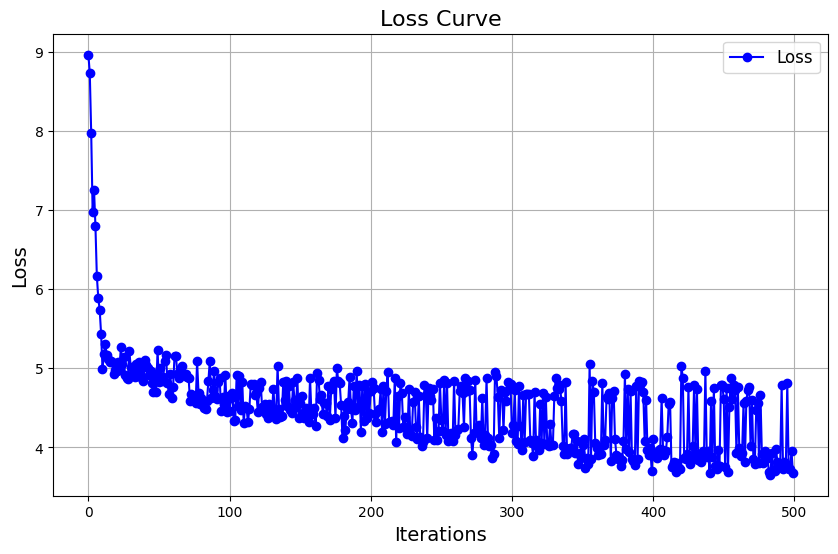

In [29]:
# Plot loss curves
plot_metrics(training_losses, 'Loss Curve', 'Loss')

In [30]:
# Set dropout layers to ``eval`` mode
encoder.eval()
decoder.eval()

# Initialize search module
searcher = GreedySearchDecoder(encoder, decoder)

# Begin chatting (uncomment and run the following line to begin)
evaluateInput(encoder, decoder, searcher, voc)


Bot (Rule-Based): Hi there! How can I assist you?
Bot (Rule-Based): Goodbye! Have a great day!
Bot: what ?
Bot: i . . .
Bot: what ?
Bot: you know . .
Bot: what ?
